# 영화 리뷰 분류: 이진 분류

## 2종 분류(two-class classification)
2종 분류(two-class classification), 이진 분류(binary classification)는 가장 널리 사용되는 머신러닝 문제중 하나이다.

## IMDB 데이터셋
 - IMDB: 인터넷 영화 데이터베이스(Internet Movie Database)로부터 가져온 데이터셋
 - MNIST 데이터셋처럼 IMDB 데이터셋도 케라스에 포함되어있다.
 - 훈련데이터 2만5000개, 테스트데이터 2만5000개로 구성되어 있고 각각 50%는 부정, 50%는 긍정 리뷰로 구성되어 있다.
 - 각 데이터는 전처리되어있고 각 리뷰(단어시퀀스)가 숫자 시퀀스로 변환되어있다.(숫자는 인덱스??)
 - 모델이 훈련데이터에서 잘 작동하는 것은 새로운 데이터에서도 잘 작동한다는 것을 보장하지 않는다.
 
## 분류 예제.. 한번 따라해보자..
### IMDB 데이터셋 로드

In [24]:
#keras.datasets모듈에서 imdb객체를 import한다.
from keras.datasets import imdb

#훈련 데이터에서 자주 나오는 단어 1만개만 사용, imdb데이터셋을 로드한다.
# (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=1000)

#당연하지만.. 최대 인덱스는 9999까지다..
max_index = max([max(sequence) for sequence in train_data])
print(max_index)

#
word_index = imdb.get_word_index()#word_index는 단어와 정수 인덱스를 매핑한 딕셔너리
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]#정수인덱스, 단어 순서로 다시 저장한다.
)
decoded_index = ' '.join(
    # 리뷰를 디코딩한다. 0,1,2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺀다.
    [reverse_word_index.get(i-3, '?') for i in train_data[0]]
)

print('train_data type: ({0},{1}) length:({2},{3})  train_data[1]: \n{4}'.format(type(train_data), type(train_data[0]), len(train_data),\
                                                                            len(train_data[1]), train_data[0]))
print('word_index type: {0}'.format(type(word_index)))
# word_index: (word, index), reverse_index: (index, word)
str_words = ''
for i in range(1, 1000):
    if i%10 == 0:
        str_words += '\n'
    str_words += '{0}\t'.format(reverse_word_index[i])

print('reverse_word_index: \n{0}'.format(str_words))
print('decoded_index type: {0} \ndecoded_index: {1}'.format(type(decoded_index), decoded_index))


999
train_data type: (<class 'numpy.ndarray'>,<class 'list'>) length:(25000,189)  train_data[1]: 
[1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
word_index type: <class 'dict'>

### 데이터 준비
신경망에 숫자리스트를 주입할 수 없다. 리스트를 텐서로 바꿔서 넣어줘야한다.
리스트를 텐서로 바꾸는 두가지 방법이 있다.
 - 리스트에 패딩을 추가하여 (samples, sequence_length) 크기의 정수 텐서로 변환, 이 텐서를 첫번째 층(Embedding층이라고 한다)으로 사용, 추후 더 자세히 설명 예정
 - 0, 1의 변환하는 방식. [3, 5]를 인덱스 3과 5의 위치는 1이고 그 외는 모두 0인 10,000차원의 벡터로 각각 변환한다. 이 방식을 원핫인코딩 방식이라고 한다.
그 중 원핫인코딩(one-hot encoding)방식을 사용해보자 

In [37]:
import numpy as np

#results[i]에서 특정인덱스의 위치를 1로 만든다.
# def vectorize_sequences(sequences, dimension=10000):
count = 0
def vectorize_sequences(sequences, dimension=1000):
    type(sequences)
    results = np.zeros((len(sequences), dimension))
    print('vectorize_sequences(): sequences len, dimension, results len, sequence[0] len : {0}, {1}, {2}, {3}'.format(sequences.shape,\
                                       dimension, results.shape, len(sequences[0])))
    global count
    for i,sequence in enumerate(sequences):
        results[i, sequence] = 1.
        print('*** {0}'.format(sequence))
        print('**** sequence: type {0}, len {1}, result type, shape: {2}, {3}'.format(type(sequence), len(sequence), type(results), (results[i]).shape))
        count = count+1
    return results

print('train_data type: ({0},{1}) length:({2},{3})\n'.format(type(train_data), type(train_data[0]),\
                                                                            len(train_data), len(train_data[1])))
x_train = vectorize_sequences(train_data)
print('list num: {0}'.format(count))
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

print(x_test.shape)
print(x_train[0])
# print(x_train.shape)


train_data type: (<class 'numpy.ndarray'>,<class 'list'>) length:(25000,189)

vectorize_sequences(): sequences len, dimension, results len, sequence[0] len : (25000,), 1000, (25000, 1000), 218
**** sequence: type <class 'list'>, len 218, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 189, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 141, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 550, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 147, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 43, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 123, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 562, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <cla

**** sequence: type <class 'list'>, len 127, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 169, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 110, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 164, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 147, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 205, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 133, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 188, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 125, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 183, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 138, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 132, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 143, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 356, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 137, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 270, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 199, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 540, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 240, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 131, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 151, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 596, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 624, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 196, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 475, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 356, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 308, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 203, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 91, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 151, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 127, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 353, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 122, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 150, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 735, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 501, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 396, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 160, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 160, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 124, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 515, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 186, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 287, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 287, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 255, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 512, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 331, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 80, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 203, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 138, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 343, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 164, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 320, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 361, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 168, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 390, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 48, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 702, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 119, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 117, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 272, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 134, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 57, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 307, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 198, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 142, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 679, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 99, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 155, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 171, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 127, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 375, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 113, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 148, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 208, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 185, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 46, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 131, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 193, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 184, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 230, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 263, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 163, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 570, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 288, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 202, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 401, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 121, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 93, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 214, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 42, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 262, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 406, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 177, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 373, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 203, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 325, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 123, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 227, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 121, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 259, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 273, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 134, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 154, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 135, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 44, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 275, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 73, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 183, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 194, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 280, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 119, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 129, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 199, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 278, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 538, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 375, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 349, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 138, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 598, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 123, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 140, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 109, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 200, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 122, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 153, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 74, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 154, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 225, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 153, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 116, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 165, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 233, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 608, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 85, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 323, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 472, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 116, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 232, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 207, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 263, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 154, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 155, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 546, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 139, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 75, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 76, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 62, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 186, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 292, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <cl

**** sequence: type <class 'list'>, len 276, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 307, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 326, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 151, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 183, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 146, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 199, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 268, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 234, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 139, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 280, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 61, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 161, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 217, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 200, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 286, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 190, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 151, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 175, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 167, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 160, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 115, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 170, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 620, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 159, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 305, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 89, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 149, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 74, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 134, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 155, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 166, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 565, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 150, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 163, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 489, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 150, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 322, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 455, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 95, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 184, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 378, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 266, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 139, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 349, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 281, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 982, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 1008, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 84, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 103, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 496, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 118, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 661, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 215, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 292, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 527, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 699, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 217, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 195, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 495, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 135, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 155, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 163, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 134, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 181, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 238, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 222, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 123, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 350, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 130, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 123, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 236, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 47, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 287, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 396, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 291, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 66, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 274, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 158, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 133, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 139, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 116, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 78, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 171, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 249, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 450, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 124, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 62, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 311, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 585, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 133, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 121, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 150, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 88, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 138, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 122, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 152, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 218, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 834, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 127, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 132, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 132, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 290, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 425, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 253, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 471, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 166, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 155, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 207, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 116, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 386, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 288, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 175, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 122, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 189, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 60, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 40, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 962, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 740, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 365, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 157, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 122, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 170, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 156, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 153, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 1016, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 538, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 135, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 452, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 139, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type

**** sequence: type <class 'list'>, len 216, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 194, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 72, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 463, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 594, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 263, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 210, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 182, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 118, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 260, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 161, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 553, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 121, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 154, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 137, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 182, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 221, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 374, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 44, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 124, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 633, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 121, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 202, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 62, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 42, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 177, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 363, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 109, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 51, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 121, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <cl

**** sequence: type <class 'list'>, len 111, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 291, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 663, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 124, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 151, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 137, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 344, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 130, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 222, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 157, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 123, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 159, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 264, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 406, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 180, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 540, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 185, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 299, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 134, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 126, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 96, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 120, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 442, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 125, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 293, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 166, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 63, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 440, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 153, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 177, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 149, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 147, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 579, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 168, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 515, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 201, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 273, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 175, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 198, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 313, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 121, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 240, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 179, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 243, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 329, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 60, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 149, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 102, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 297, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 145, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 127, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 314, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 89, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 25, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 396, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 408, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 243, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 612, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 251, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 139, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 102, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 159, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 688, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 59, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 80, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 176, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 137, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 859, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 147, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 489, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 245, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 129, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 143, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 35, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 48, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 197, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 119, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 106, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 361, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 174, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 164, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 141, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 145, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 125, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 198, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 118, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 119, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 861, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 145, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 69, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 172, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 375, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 38, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 95, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 76, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 773, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 196, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 119, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 228, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 134, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <cl

**** sequence: type <class 'list'>, len 52, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 70, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 49, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 229, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 187, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 178, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 171, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 141, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 263, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 72, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <cla

**** sequence: type <class 'list'>, len 106, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 110, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 168, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 210, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 570, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 202, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 109, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 105, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 454, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 282, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 195, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 126, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 961, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 124, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 283, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 168, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 405, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 675, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 218, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 185, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 363, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 208, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 303, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 62, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 70, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 585, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 159, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 122, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 218, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 78, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <cl

**** sequence: type <class 'list'>, len 261, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 172, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 217, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 42, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 256, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 579, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 518, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 157, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 182, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 129, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 365, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 158, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 330, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 135, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 143, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 46, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 110, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 203, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 148, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 214, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 117, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 510, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 171, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 315, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 427, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 236, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 239, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 116, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 124, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 310, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 282, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 240, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 115, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 212, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 110, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 148, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 122, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 108, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 162, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 505, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 212, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 304, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 233, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 504, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 211, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 274, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 240, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 403, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 199, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 126, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 97, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 129, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 128, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 227, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 182, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 312, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 262, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 95, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 569, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 182, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 132, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 188, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 131, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 111, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 206, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 126, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 321, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 95, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 299, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 232, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 165, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 416, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 437, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 201, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 141, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 144, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 123, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 349, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 124, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 145, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 36, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 118, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 261, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 173, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 121, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 147, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 49, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 129, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 137, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 149, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 195, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 112, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 135, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 355, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 161, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 424, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 205, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 142, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 101, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 139, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 113, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 257, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 138, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 471, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 268, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 67, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 389, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 215, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 53, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 102, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 369, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 42, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 215, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 109, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 633, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 300, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 85, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 307, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 431, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 168, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 120, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 87, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 168, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 163, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 153, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 150, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 356, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 183, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 220, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 162, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 70, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 119, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 123, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 70, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 145, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 165, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 566, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 62, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 191, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 140, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <cl

**** sequence: type <class 'list'>, len 692, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 180, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 154, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 303, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 511, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 204, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 426, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 62, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 353, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 110, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 148, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 479, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 147, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 155, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 158, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 148, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 478, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 280, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 226, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 266, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 134, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 152, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 102, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 324, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 114, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 153, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 605, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 802, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 323, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 201, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 422, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 48, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 192, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 169, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 175, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 154, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 310, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 123, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 118, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 53, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 223, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 191, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 157, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 186, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 207, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 107, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 129, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 118, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 154, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 188, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 272, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 174, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 136, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 160, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 160, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 113, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 160, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 159, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 251, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 115, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

**** sequence: type <class 'list'>, len 154, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 83, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 124, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 57, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 574, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 133, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 111, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 500, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 140, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 168, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 936, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 139, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 394, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 432, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 207, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 227, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 154, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 436, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 87, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 59, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <c

**** sequence: type <class 'list'>, len 47, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 125, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 330, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 288, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 181, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 275, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 160, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 313, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 157, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 158, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <

**** sequence: type <class 'list'>, len 286, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 254, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 138, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 246, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 127, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 130, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 174, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 585, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 125, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type <class 'list'>, len 431, result type, shape: <class 'numpy.ndarray'>, (1000,)
**** sequence: type 

## 신경망 모델 만들기 - model 정의

In [4]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

##  신경망 모델 만들기 - model 컴파일, 옵티마이저 설정

In [5]:
model.compile(optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy'])
# 아래와 같이 optimizer 객체를 사용할 수도 있다.
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

## 훈련 검증
 - 훈련하는 동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해 원본 훈련 데이터에서 1000의 샘플을 떼어서 검증 세트를 만든다.  
 - 이제 모델을 512개 샘플씩 미니 배치를 만들어 20번의 에포크 동안 훈련시킨다(x_train과 y_train 텐서에 있는 모든 샘플에 대해 20번 반복한다).  
 - 따로 떼어 놓은 10,00개의 샘플에서는 손실과 정확도를 측정해보자. 이렇게 하려면 validation_data 매개변수에 검증 데이터를 전달한다.

In [6]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]


## 모델 훈련
model.fit() 메서드는 History 객체를 반환한다.  
이 객체는 훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리인 history 속성을 가지고 있습니다. 한 번 확인해 보죠:
~~~python
In [18]:
history_dict = history.history
history_dict.keys()
Out[18]:
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
~~~

In [7]:
model.compile(optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Train on 24000 samples, validate on 1000 samples
Epoch 1/20
24000/24000 [==============================] - 1s 24us/step - loss: 0.5158 - acc: 0.7613 - val_loss: 0.4029 - val_acc: 0.8200
Epoch 2/20
24000/24000 [==============================] - 0s 18us/step - loss: 0.3678 - acc: 0.8468 - val_loss: 0.3383 - val_acc: 0.8660
Epoch 3/20
24000/24000 [==============================] - 0s 14us/step - loss: 0.3310 - acc: 0.8617 - val_loss: 0.3232 - val_acc: 0.8610
Epoch 4/20
24000/24000 [==============================] - 0s 14us/step - loss: 0.3163 - acc: 0.8681 - val_loss: 0.3187 - val_acc: 0.8630
Epoch 5/20
24000/24000 [==============================] - ETA: 0s - loss: 0.3116 - acc: 0.869 - 0s 15us/step - loss: 0.3084 - acc: 0.8716 - val_loss: 0.3364 - val_acc: 0.8450
Epoch 6/20
24000/24000 [==============================] - 0s 19us/step - loss: 0.3055 - acc: 0.8732 - val_loss: 0.3153 - val_acc: 0.8640
Epoch 7/20
24000/24000 [==============================] - 0s 18us/step - loss: 0.2994 - acc

## 훈련과 검증 손실, 정확도에 대한 실험결과..
 - 훈련 손실이 에포크마다 감소하고 훈련 정확도는 에포크마다 증가한다. 경사 하강법 최적화를 사용했을 때 반복마다 최소화되는 것이 손실이므로 기대했던 대로이다.
 - 검증 손실과 정확도는 이와 같지 않다. 4번째 에포크에서 그래프가 역전되고 있다. 훈련 세트에서 잘 작동하는 모델이 처음 보는 데이터에 잘 작동하지 않을 수 있다고 앞서 언급한 경고의 한 사례이다. 정확한 용어로 말하면 과대적합(over-fitting)되었다고 한다.
 - 2번째 에포크 이후부터 훈련 데이터에 과도하게 최적화되어 훈련 데이터에 특화된 표현을 학습하므로 훈련 세트 이외의 데이터에는 일반화되지 못한다.
 - 과대적합(over-fitting)을 방지하기 위해서 3번째 에포크 이후에 훈련을 중지할 수 있다. 일반적으로 4장에서 보게 될 과대적합을 완화하는 다양한 종류의 기술을 사용할 수 있다.  
  
아래의 훈련과 검증 손실, 정확도에 대해 그려본 그래프를 확인해보자  

## 훈련과 검증 손실 그리기

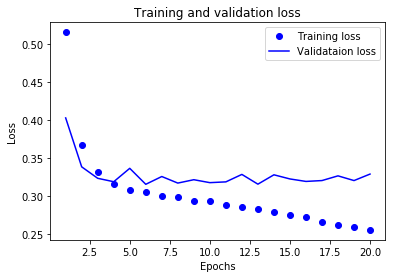

In [10]:
import matplotlib.pyplot as plt
plt.clf()
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validataion loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 훈련과 검증 정확도 그리기

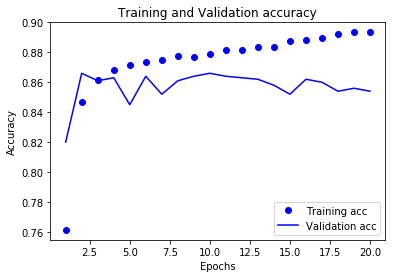

In [12]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 모델을 처음부터 다시 훈련하기 -> 왜 처음부터 다시 훈련?

In [13]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy'])

# 훈련된 모델로 새로운 데이터 예측하기
 - 모델을 훈련시킨 후에 이를 실전 환경에서 사용하고 싶을 것이다. predict 메서드를 사용해서 어떤 리뷰가 긍정일 확률을 예측할 수 있다.
 - 여기에서처럼 이 모델은 어떤 샘플에 대해 확신을 가지고 있지만(0.99 또는 그 이상, 0.01 또는 그 이하) 어떤 샘플에 대해서는 확신이 부족하다. (0.6, 0.4).

In [14]:
model.predict(x_test)

array([[0.4735026 ],
       [0.46398994],
       [0.45537943],
       ...,
       [0.49687773],
       [0.48598835],
       [0.5136634 ]], dtype=float32)

# 더 해볼만한 것들
 - 여기에서는 두 개의 은닉층을 사용했습니다. 한 개 또는 세 개의 은닉층을 사용하고 검증과 테스트 정확도에 어떤 영향을 미치는지 확인해 보세요.
 - 층의 은닉 유닛을 추가하거나 줄여 보세요: 32개 유닛, 64개 유닛 등
 - binary_crossentropy 대신에 mse 손실 함수를 사용해 보세요.
 - relu 대신에 tanh 활성화 함수(초창기 신경망에서 인기 있었던 함수입니다)를 사용해 보세요.
 
# 정리
다음은 이 예제에서 배운 것들입니다:
- 원본 데이터를 신경망에 텐서로 주입하기 위해서는 꽤 많은 전처리가 필요합니다. 단어 시퀀스는 이진 벡터로 인코딩될 수 있고 다른 인코딩 방식도 있습니다.
- relu 활성화 함수와 함께 Dense 층을 쌓은 네트워크는 (감성 분류를 포함하여) 여러 종류의 문제에 적용할 수 있어서 앞으로 자주 사용하게 될 것입니다.
- (출력 클래스가 두 개인) 이진 분류 문제에서 네트워크는 하나의 유닛과 sigmoid 활성화 함수를 가진 Dense 층으로 끝나야 합니다. 이 신경망의 출력은 확률을 나타내는 0과 1 사이의 스칼라 값입니다.
- 이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용할 손실 함수는 binary_crossentropy입니다.
- rmsprop 옵티마이저는 문제에 상관없이 일반적으로 충분히 좋은 선택입니다. 걱정할 거리가 하나 줄은 셈입니다.
- 훈련 데이터에 대해 성능이 향상됨에 따라 신경망은 과대적합되기 시작하고 이전에 본적 없는 데이터에서는 결과가 점점 나빠지게 됩니다. 항상 훈련 세트 이외의 데이터에서 성능을 모니터링해야 합니다.